## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures
from src.models.HardSphereGAN import GAN, HSGenerator, HSDiscriminator
from src.models.StaticScaler import StaticMinMaxScaler

%cd -

plt.set_cmap("viridis")

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


<Figure size 640x480 with 0 Axes>

# Hard spheres model development


First stage: Develop a CNN - based GAN to work with ordered point clouds.'

This notebook is an attempt at the simpler hexagonal and square lattices after slow progress in the full-scale experiment.

In [3]:

phis = [0.86] # Add more phis here

path = Path("../data/raw/samples")
path = Path("../data/raw/crystal/Hex")
path = Path("../data/raw/crystal/Sq")


files, dataframe, metadata = load_raw_data(path, phi=phis, subpath="disorder-0.2")

dataframe.sort_index()

Number of Files found :  100


class         x         y    r
experiment   sample                                   
disorder-0.2 sample-1       1 -0.030240  0.007020  0.5
             sample-1       1  1.006492  0.022341  0.5
             sample-1       1  1.844643 -0.067134  0.5
             sample-1       1  2.776907 -0.018990  0.5
             sample-1       1  3.762064  0.056676  0.5
...                       ...       ...       ...  ...
             sample-99      1 -4.829105 -1.041648  0.5
             sample-99      1 -3.826874 -1.054693  0.5
             sample-99      1 -2.966799 -1.045362  0.5
             sample-99      1 -1.973816 -0.890333  0.5
             sample-99      1 -0.928135 -0.879420  0.5

[160000 rows x 4 columns]

In [57]:
# Hex lattice

N = 1600 
X_box = 41.076212368516387
Y_box = 35.573043402379753   
 
# Square lattice
N = 1600
X_box = 38.225722823651111
y_box = 38.225722823651111 
dataframe["r"] = 0.375 # Fixed radius for all data, for square lattice

In [58]:
from torch import cdist

xy = torch.from_numpy(dataframe.query("sample=='sample-79'")[["x","y"]].values)

dist = cdist(xy[:, :2], xy[:, :2])

dist

tensor([[0.0000, 0.7948, 1.7465,  ..., 3.1837, 2.2164, 1.4724],
        [0.7948, 0.0000, 0.9618,  ..., 3.9627, 2.9675, 2.1508],
        [1.7465, 0.9618, 0.0000,  ..., 4.8649, 3.8387, 2.9705],
        ...,
        [3.1837, 3.9627, 4.8649,  ..., 0.0000, 1.0617, 1.9684],
        [2.2164, 2.9675, 3.8387,  ..., 1.0617, 0.0000, 0.9070],
        [1.4724, 2.1508, 2.9705,  ..., 1.9684, 0.9070, 0.0000]],
       dtype=torch.float64)

In [61]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StaticMinMaxScaler(
    columns = ["x", "y", "r"],
    maximum = [X_box, Y_box, 2*X_box], # NOTE: Tuned for physical feasibility
    minimum = [-X_box, -Y_box, 0] # NOTE: Tuned for physical feasibility
)

dataframe_scaled = pd.DataFrame(scaler.transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r
# dataframe_scaled = dataframe_scaled.sort_values(by=["experiment", "sample"])
dataframe_scaled.describe().round(7)

,x,y,r
count,160000.000000,160000.000000,160000.000000
mean,0.500040,0.500068,0.004905
std,0.144402,0.155169,0.000000
min,0.250000,0.231358,0.004905
25%,0.375014,0.365690,0.004905
50%,0.500025,0.500002,0.004905
75%,0.624984,0.634314,0.004905
max,0.749999,0.768642,0.004905


# Plot an example

torch.Size([1, 1600, 3])


<Axes: >

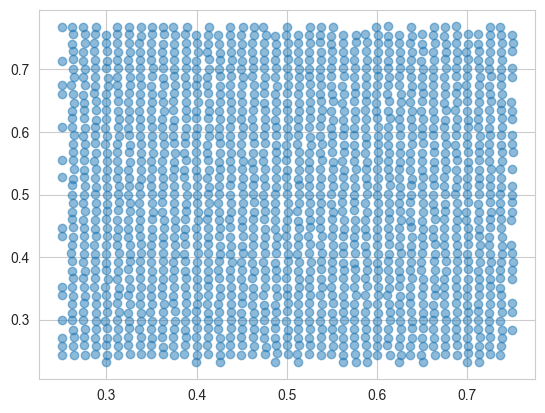

In [62]:
sample = dataframe_scaled.copy().query("(sample=='sample-1')").loc[:,["x", "y", "r"]].reset_index(drop=True)
sample = torch.tensor(sample.values).unsqueeze(0)
print(sample.shape)
plot_pointcloud(sample[0], plot_radius=False)

## Build dataset

Creating Dataset
Descriptor List:  ['phi']
torch.Size([200, 1, 1])
torch.Size([200, 1600, 3])


/Users/veikko/Documents/GitHub/hard-spheres/src/HSDataset.py:31: PerformanceWarning: indexing past lexsort depth may impact performance.
  dataframe.loc[(experiment, sample), :].copy().values,


<Axes: >

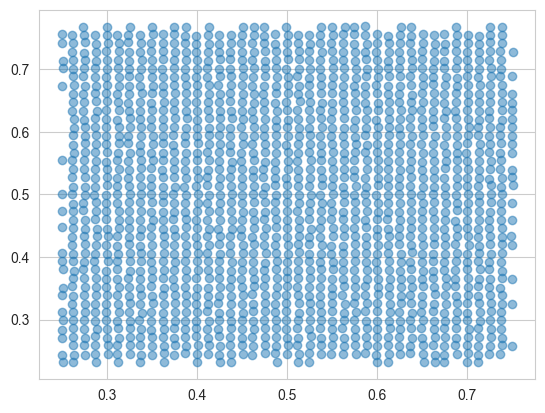

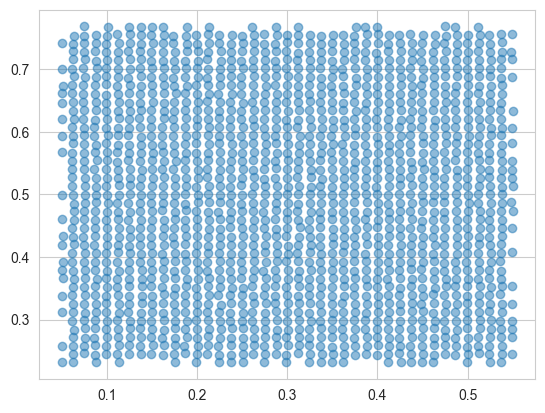

In [63]:
## Build dataset
from src.HSDataset import HSDataset

dataset = HSDataset(
    dataframe_scaled.copy(), # Dont use the ordering
    descriptor_list=["phi"],
    synthetic_samples={"rotational": 0, "shuffling": 0, "spatial_offset_static": 0.2}, 
    downsample=False
    )
print(dataset[:][0].shape)
print(dataset[:][1].shape)

# Create a function that visualizes the point cloud
plot_pointcloud(dataset[0][1], plot_radius=False)
plot_pointcloud(dataset[-1][1], plot_radius=False)

# Create model

Create a GAN architecture, which creates point clouds $\hat{y}$ based on the descriptor(s) $\hat{X}$ and a random noise vector $\hat{z}$.

In [71]:
sample_x = dataset[0:32][0].cpu()#.transpose(-1,-2)
sample_y = dataset[0:32][1].cpu()

sample_x_mps = sample_x.to("mps")
sample_y_mps = sample_y.to("mps")

print(sample_x.shape, sample_y.shape)


torch.Size([32, 1, 1]) torch.Size([32, 1600, 3])


In [72]:
# Make a generator model as described in the paper
# paper: https://arxiv.org/pdf/2404.06734

in_features = 64
kernel_size = (3,3) # if 3x3, the output x,y,r will correlate with each other
stride = (1,1)

from src.models.CryinGAN import Generator, CCCGenerator

out_samples = dataset.samples[0].shape[1]

generator_model_2 = CCCGenerator(kernel_size=1, stride=1,
    rand_features=64, out_dimensions=2, fix_r=0.5, out_samples=out_samples).to("mps")

print(sample_x.shape)
_out = generator_model_2(sample_x).detach().cpu()
print(_out.shape)

print(summary(generator_model_2, input_data=sample_x, depth=2))


# plot_pointcloud(_out[0], plot_radius=False)
# plt.xlim(0,1)
# plt.ylim(0,1)

torch.Size([32, 1, 1])
torch.Size([32, 1600, 3])
Layer (type:depth-idx)                   Output Shape              Param #
CCCGenerator                             [32, 1600, 3]             --
├─Sequential: 1-1                        [32, 1600, 2]             --
│    └─Linear: 2-1                       [32, 64]                  4,160
│    └─ReLU: 2-2                         [32, 64]                  --
│    └─Linear: 2-3                       [32, 64]                  4,160
│    └─ReLU: 2-4                         [32, 64]                  --
│    └─Linear: 2-5                       [32, 9600]                624,000
│    └─ReLU: 2-6                         [32, 9600]                --
│    └─Unflatten: 2-7                    [32, 6, 1600, 1]          --
│    └─ConvTranspose2d: 2-8              [32, 128, 1600, 2]        1,664
│    └─BatchNorm2d: 2-9                  [32, 128, 1600, 2]        256
│    └─ReLU: 2-10                        [32, 128, 1600, 2]        --
│    └─ConvTranspose2

In [142]:
import torch
import torch.nn as nn
from src.models.CryinGAN import Discriminator2D, CCCGDiscriminator
from src.models.CryinGAN import Generator, CCCGenerator, CCCGeneratorWithDiffusion


# Initialize the discriminator
input_channels = sample_y.shape[-1] # For fractional coordinates
in_samples = sample_y.shape[1] # For fractional coordinates
discriminator_model_2 = CCCGDiscriminator(input_channels=input_channels, in_samples=in_samples).to("mps")
discriminator_model_2 = Discriminator2D(input_channels=input_channels, in_samples=in_samples).to("mps")

# Print the discriminator architecture

# Example input with batch size of 16 and 3 input channels (for fractional coordinates)
batch_size = 32
# Generate output


print(sample_y_mps.shape)
output = discriminator_model_2(sample_y_mps)
print(output.shape)

summary(discriminator_model_2, input_data=sample_y_mps, depth=2)

torch.Size([32, 1600, 3])
torch.Size([32, 1])


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator2D                          [32, 1]                   --
├─Sequential: 1-1                        [32, 256]                 --
│    └─Flatten: 2-1                      [32, 4800]                --
│    └─Unflatten: 2-2                    [32, 3, 1600]             --
│    └─Unflatten: 2-3                    [32, 3, 100, 16]          --
│    └─Conv2d: 2-4                       [32, 256, 50, 8]          12,544
│    └─LeakyReLU: 2-5                    [32, 256, 50, 8]          --
│    └─Conv2d: 2-6                       [32, 256, 25, 4]          1,048,832
│    └─LeakyReLU: 2-7                    [32, 256, 25, 4]          --
│    └─Conv2d: 2-8                       [32, 256, 12, 2]          1,048,832
│    └─LeakyReLU: 2-9                    [32, 256, 12, 2]          --
│    └─AdaptiveAvgPool2d: 2-10           [32, 256, 1, 1]           --
│    └─Flatten: 2-11                     [32, 256]                 

## Train the model

In [256]:
run_params = {
    "training":{
        "device": "mps" if torch.backends.mps.is_available() else "cpu", # MPS is not supported by PyTorch 2D TransposeConv
        "batch_size": 32,
        "epochs": 1000,
        "early_stopping_patience": -1, # Disabled
        "early_stopping_headstart": 20,
        "log_image_frequency": 1,
        "generator_headstart": 0,
        "training_ratio_dg": 3,
        "optimizer_g": {
            "name": "Adam",
            "lr": 0.0001, # 0.00005, #0.002, 
            #hypergrad_lr": 1e-8,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "optimizer_d": {
            "name": "Adam",
            "lr": 0.0001, #0.002, 
            # "hypergrad_lr": 1e-8,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "d_loss":{
            "name": "CryinGANDiscriminatorLoss", # CryinGANDiscriminatorLoss for WaGAN + L1 loss, BCELoss for baseline
            "mu": .5, # L1 loss coefficient
        },
        "g_loss":{
            "name": "HSGeneratorLoss",
            "radius_loss": 0,
            "grid_density_loss": 0,
            "gan_loss": 1,
            "distance_loss": 1,
            "physical_feasibility_loss": 0,
            "coefficients":{
                "gan_loss": 1,
                "radius_loss": 1,
                "grid_density_loss": 100,
                "physical_feasibility_loss": 10,
                "distance_loss": 100,
            },
        }
    },
    "dataset":{
        "descriptor_list": ["phi"],
        "synthetic_samples":{
            "rotational": 0,
            "shuffling": 0,
            "spatial_offset_static": 0.2 
            }, # NOTE: Could do subsquares and more rotations.
        "downsample": False
    }
}

dataset = HSDataset(
    dataframe_scaled.copy(), # Dont use the ordering
    **run_params["dataset"]
    )
dataset.x.shape

Creating Dataset
Descriptor List:  ['phi']


/Users/veikko/Documents/GitHub/hard-spheres/src/HSDataset.py:31: PerformanceWarning: indexing past lexsort depth may impact performance.
  dataframe.loc[(experiment, sample), :].copy().values,


torch.Size([200, 1, 1])

Layer (type:depth-idx)                   Output Shape              Param #
CCCGenerator                             [32, 1600, 3]             --
├─Sequential: 1-1                        [32, 1600, 2]             --
│    └─Linear: 2-1                       [32, 409600]              210,534,400
│    └─ReLU: 2-2                         [32, 409600]              --
│    └─Unflatten: 2-3                    [32, 256, 1600, 1]        --
│    └─ConvTranspose2d: 2-4              [32, 128, 1600, 2]        65,664
│    └─BatchNorm2d: 2-5                  [32, 128, 1600, 2]        256
│    └─ReLU: 2-6                         [32, 128, 1600, 2]        --
│    └─ConvTranspose2d: 2-7              [32, 64, 1600, 2]         8,256
│    └─BatchNorm2d: 2-8                  [32, 64, 1600, 2]         128
│    └─ReLU: 2-9                         [32, 64, 1600, 2]         --
│    └─ConvTranspose2d: 2-10             [32, 32, 1600, 2]         2,080
│    └─BatchNorm2d: 2-11                 [32, 32, 1600, 2]      

<Axes: >

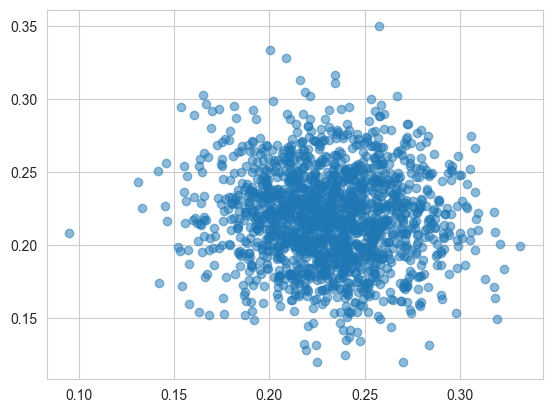

In [257]:
test_frac = 0.2

dataset = dataset.to(run_params["training"]["device"])

trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])

len(trainset), len(testset)

out_samples = dataset.samples[0].shape[1]
out_dimensions = 2 #dataset.samples[0].shape[2]

kernel_size = (1,1)
stride=1

generator = CCCGenerator(
    kernel_size=kernel_size,
    stride=stride,
    rand_features=513,
    out_dimensions=out_dimensions,
    out_samples=out_samples,
    latent_dim=256, # initial latent channels
    fix_r=0.004905,
    clip_output = (
        dataset.y.min(dim=0).values.min(dim=0).values,
        dataset.y.max(dim=0).values.max(dim=0).values, 
    )
    ).to("mps")

# NOTE: Alternative generator with diffusion
# generator = CCCGeneratorWithDiffusion(
#     kernel_size=kernel_size,
#     channels_coefficient=5,
#     stride=stride,
#     rand_features=513,
#     out_dimensions=out_dimensions,
#     out_samples=out_samples,
#     latent_dim=256, # initial latent channels
#     fix_r=0.004905,
#     clip_output = (
#         dataset.y.min(dim=0).values.min(dim=0).values,
#         dataset.y.max(dim=0).values.max(dim=0).values
#         )
#     ).to("mps")


discriminator = CCCGDiscriminator(
    input_channels=input_channels, 
    in_samples=out_samples, 
    kernel_size=(1,1),
    channels_coefficient=1
    ).to("mps")

gan = GAN(
    dataset, 
    dataset,# No separate test set
    generator_model=generator,
    discriminator_model=discriminator,
    **run_params
    )

print(summary(gan.generator, input_data=sample_x, depth=2))
print(summary(gan.discriminator, input_data=sample_y_mps, depth=2))

_out = gan.generate(sample_x)[0]
# _out = _out.numpy()

plot_pointcloud(_out, plot_radius=False)

In [258]:
gan.train_n_epochs(
    epochs=run_params["training"]["epochs"],
    batch_size=run_params["training"]["batch_size"],
    experiment_name="Square lattice (Fixed r=0.5)",
)

2024/10/11 18:05:43 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/10/11 18:05:43 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Starting run car-forest-9fcf22e0-845f-4d5e-ac1b-e634a24e48ad...
Time: 2024-10-11 18:05:43


  1%|▏         | 13/1000 [02:16<2:52:28, 10.48s/it]
2024/10/11 18:08:00 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/10/11 18:08:00 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Interrupted


<Axes: >

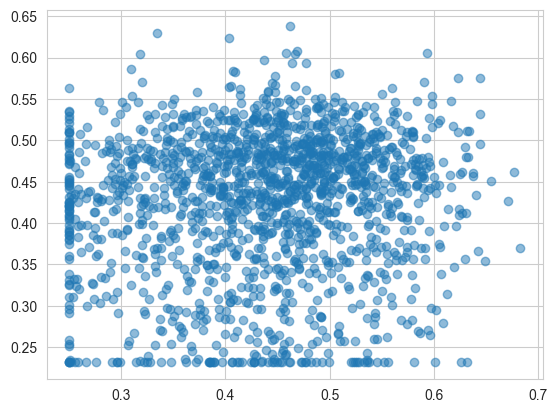

In [89]:
_out = gan.generate(sample_x)[0]
# _out = _out.numpy()

plot_pointcloud(_out, plot_radius=False)

torch.Size([32, 1600, 3])
torch.Size([32, 1])
tensor(1.0000, device='mps:0', grad_fn=<MeanBackward0>)


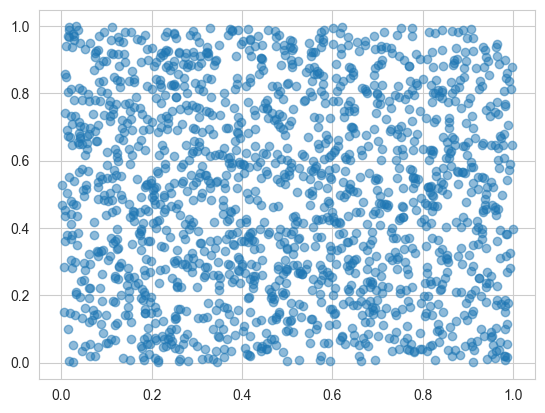

In [168]:
# Test the discriminator with random data

# Generate random data
random_data = torch.rand_like(sample_y).to("mps")
print(random_data.shape)

plot_pointcloud(random_data[0].cpu().numpy(), plot_radius=False)

# Test the discriminator

output = gan.discriminator(random_data)
print(output.shape)
print(output.mean())
plt.show()

## Review the interpolation

In [210]:
real_labels = torch.ones_like(sample_x).squeeze(-1) - 0.1
fake_labels = torch.zeros_like(sample_x).squeeze(-1) + 0.1

bce = nn.BCELoss()

fake_images = gan.generate(sample_x).to("mps")
real_images = sample_y_mps

real_outputs = gan.discriminator(real_images).cpu()
fake_outputs = gan.discriminator(fake_images).cpu()

d_loss = bce(real_outputs, real_labels) + bce(
    fake_outputs, fake_labels
)

# Gradient penalty term
alpha = torch.rand(real_images.size(0), 1, 1).to(real_images.device)
interpolates_coord = alpha * real_images + (1 - alpha) * fake_images
interpolates_coord.requires_grad_(True)
d_interpolates_coord = discriminator(interpolates_coord)

grad_outputs_coord = torch.ones(d_interpolates_coord.size()).to(
    real_images.device
)

gradients = torch.autograd.grad(
    outputs=d_interpolates_coord,
    inputs=interpolates_coord,
    grad_outputs=grad_outputs_coord,
    create_graph=True,
    retain_graph=True,
    only_inputs=True,
)[0]

(0.0, 1.0)

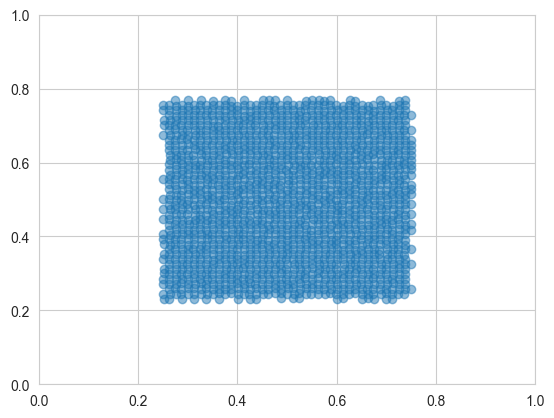

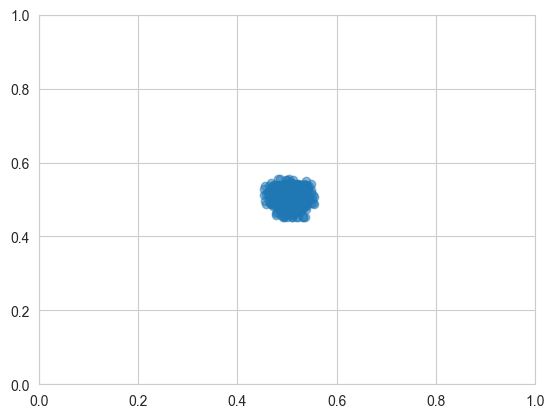

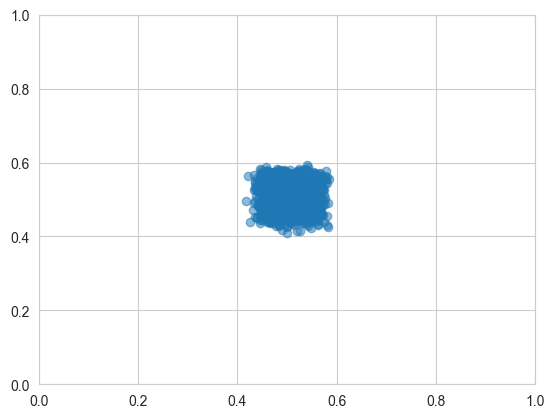

In [213]:
plot_pointcloud(real_images[0].cpu().detach(), plot_radius=False)
plt.xlim(0,1)
plt.ylim(0,1)
plot_pointcloud(fake_images[0].cpu().detach(), plot_radius=False)
plt.xlim(0,1)
plt.ylim(0,1)
plot_pointcloud(interpolates_coord[0].cpu().detach(), plot_radius=False)
plt.xlim(0,1)
plt.ylim(0,1)